# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\Users\Atharva Darkonde\AppData\Roaming\Python\Python312\site-packages\packaging\requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\Atharva Darkonde\AppData\Roaming\Python\Python312\site-packages\packaging\_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\Atharva Darkonde\AppData\Roaming\Python\Python312\site-packages\packaging\_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [4]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.1.0
aiofiles                  23.2.1
altair                    5.5.0
annotated-types           0.7.0
anyio                     4.4.0
asgiref                   3.8.1
asttokens                 2.4.1
astunparse                1.6.3
attrs                     25.3.0
beautifulsoup4            4.13.3
blinker                   1.8.2
cachetools                5.5.2
certifi                   2024.7.4
charset-normalizer        3.4.1
click                     8.1.7
colorama                  0.4.6
comm                      0.2.2
comtypes                  1.4.5
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
distlib                   0.3.9
distro                    1.9.0
Django                    5.1.7
executing                 2.1.0
extensions                0.4
fastapi                   0.115.12
feedparser              

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

: 

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,688 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
[7.8866822e-01 7.2185823e-04 3.2794494e-02 8.9074047e-03 1.7814541e-01
 4.4356577e-02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
[7.8866822e-01 7.2185823e-04 3.2794494e-02 8.9074047e-03 1.7814541e-01
 4.4356577e-02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
[0.9460672  0.02231286 0.4471473  0.02138855 0.7085281  0.11948346]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
[0.7327299  0.12162042 0.1461107  0.20611739 0.2384896  0.27445322]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
[0.760712   0.11312202 0.15198974 0.24345943 0.28234813 0.3377989 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
[3.0061403e-02 2.1418744e-05 5.3457741e-04 4.4598529e-04 1.8938567e-03
 1.3523201e-03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
[0.9753436  0.02062954 0.6002636  0.01247426 0.7767627  0.09258947]


In [18]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 610s 86ms/step - loss: 0.0831 - val_loss: 0.0443
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 659s 94ms/step - loss: 0.0474 - val_loss: 0.0391
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 668s 96ms/step - loss: 0.0413 - val_loss: 0.0359
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 655s 94ms/step - loss: 0.0353 - val_loss: 0.0302
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 638s 91ms/step - loss: 0.0316 - val_loss: 0.0286


In [19]:
model.save('toxicity_after_train.h5')

In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

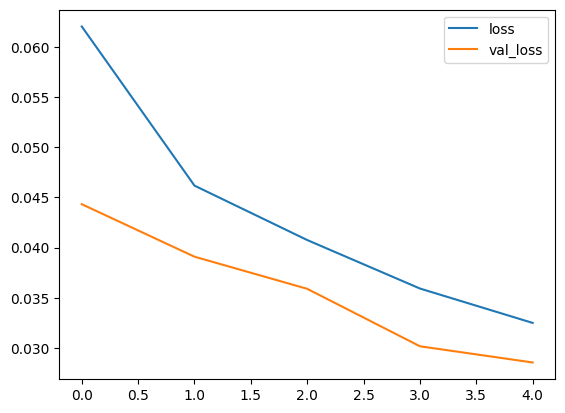

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [20]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [21]:
print(res)

NameError: name 'res' is not defined

In [22]:
# Reshape the input to have a batch dimension
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text = np.expand_dims(input_text, axis=0)  # Add batch dimension

# Check the shape before prediction
print(f"Input shape: {input_text.shape}")

# Now predict
res = model.predict(input_text)

Input shape: (1, 1800)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [23]:
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [25]:
(res > 0.5).astype(int)

array([[0, 0, 0, 1, 0, 1]])

In [24]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [36]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1]])

In [37]:
res.shape

(1, 6)

# 4. Evaluate Model

In [9]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [10]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [2]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

NameError: name 'test' is not defined

In [1]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

NameError: name 'pre' is not defined

# 5. Test and Gradio

In [34]:
model.save('toxicity.h5')

In [39]:
!pip install gradio jinja2

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
import gradio as gr

C:\Users\Atharva Darkonde\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from tensorflow.keras.layers import TextVectorization
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)

In [28]:
model = tf.keras.models.load_model('toxicity.h5')

In [43]:
input_str = vectorizer('hey i freaken hate you!')

In [44]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


In [45]:
res

array([[0.876179  , 0.00162066, 0.07148195, 0.01161802, 0.35377595,
        0.06644098]], dtype=float32)

In [29]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    print(results[0])
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        if(idx == 3): 
            text += '{}: {}\n'.format(col, results[0][idx]>0.2)
        else: 
            text += '{}: {}\n'.format(col, results[0][idx]>0.3)
            
    return text

In [48]:
score_comment("I just saw a man running naked on street")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
[2.3013351e-02 7.7967416e-06 3.4964387e-04 1.6197632e-04 1.0625486e-03
 5.7571358e-04]


'toxic: False\nsevere_toxic: False\nobscene: False\nthreat: False\ninsult: False\nidentity_hate: False\n'

In [30]:


import gradio as gr

interface = gr.Interface(
    fn=score_comment, 
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs=gr.Textbox()
)




In [ ]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
[7.8866822e-01 7.2185823e-04 3.2794494e-02 8.9074047e-03 1.7814541e-01
 4.4356577e-02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
[0.68966436 0.0949375  0.12482568 0.20166573 0.21795386 0.26244476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
[1.5776029e-02 6.5556860e-06 2.1224747e-04 1.3455159e-04 6.1323110e-04
 4.7390765e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
[0.9943132  0.08158457 0.9486145  0.00484567 0.77684945 0.03717592]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
[0.98222715 0.03313353 0.6664841  0.02118688 0.82284784 0.14692523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
[0.760712   0.11312202 0.15198974 0.24345943 0.28234813 0.3377989 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[0.7310101  0.00935192 0.07280605 0.07939107 0.316531   0.19834308]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
[0.888558   0.20304048 0.26726788 0.26067778 0.40757015 0.42153302]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
[0.9899466  0.2639738  0.93226314 0.04376816 0.7840148  0.17628953]